In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Reading Data

In [192]:
gdp_df = pd.read_csv('../data/gdp-data/SQGDP2__ALL_AREAS_2005_2021.csv')
vax_df = pd.read_csv('../data/vaccination-data/us_state_vaccinations.csv')

# Processing Vaccination Data

First, I'll aggregate states' vaccination rates per 1000 into quarterly numbers.

In [193]:
def find_quarter(date):
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    if datetime_object.month <= 3:
        return str(datetime_object.year)+":Q1"
    elif datetime_object.month <= 6:
        return str(datetime_object.year)+":Q2"
    elif datetime_object.month <= 9:
        return str(datetime_object.year)+":Q3"
    else:
        return str(datetime_object.year)+":Q4"

In [194]:
vax_df_quarterly = vax_df.copy()
vax_df_quarterly['quarter'] = vax_df_quarterly['date'].apply(find_quarter)

Cleaning the vaccination data set
* Removing unnecessary data columns
* Finding maxes per quarter (or for daily, aggregating per quarter)
* Removing locations that don't correlate with other data (pretty much restricting to states)
* Drop NA?

In [195]:
vax_df_quarterly = vax_df_quarterly[['quarter', 'location', 'people_fully_vaccinated_per_hundred', 
                                    'total_vaccinations_per_hundred', 'distributed_per_hundred',
                                    'daily_vaccinations_per_million']]

In [196]:
# Note - new york is listed as New York State for some reason, so we need to convert it to make state names match easily
vax_df_quarterly.loc[vax_df_quarterly['location'] == 'New York State', 'location'] = 'New York'

In [197]:
state_names = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming", 'District of Columbia']

In [198]:
vax_df_quarterly = vax_df_quarterly[vax_df_quarterly['location'].isin(state_names)]

In [199]:
summarized_vax_quarterly = vax_df_quarterly.groupby(['quarter', 'location']).agg({'people_fully_vaccinated_per_hundred': 'max',
                                                                                'total_vaccinations_per_hundred': 'max',
                                                                                'distributed_per_hundred': 'max',
                                                                                'daily_vaccinations_per_million': 'mean'}).reset_index()

In [200]:
summarized_vax_quarterly

,quarter,location,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,daily_vaccinations_per_million
0,2021:Q1,Alabama,13.40,35.26,57.04,4178.782051
1,2021:Q1,Alaska,22.30,55.67,82.19,6542.525641
2,2021:Q1,Arizona,17.07,47.42,59.13,5634.564103
3,2021:Q1,Arkansas,13.90,39.21,58.44,5049.897436
4,2021:Q1,California,16.07,46.12,59.88,5410.820513
...,...,...,...,...,...,...
199,2021:Q4,Virginia,64.94,153.49,183.10,4179.885246
200,2021:Q4,Washington,65.04,149.41,183.54,3755.983607
201,2021:Q4,West Virginia,41.54,94.35,188.66,1341.377049
202,2021:Q4,Wisconsin,59.50,140.75,159.59,3907.081967


Note: this data only includes states from Q1 2021 to Q2 2022 because vaccine rollout was almost non-existent before Q1 2021, and the data collection pipelines were not state-specific. The final total_vaccinations_per_hundred on 11/30/2020 was .84

# Processing GDP Data and Merging into Summarized Vax

I'll start by dropping the unnecessary columns to avoid confusion.

Note, I removed the unit because everything is "Millions of current dollars" (not Real GDP chained to 2012, but instead current dollar values as of October 2021)

In [201]:
gdp_df = gdp_df[['GeoName','Description','2021:Q2','2021:Q1','2020:Q4','2020:Q3','2020:Q2','2020:Q1']]

Now I'll start cleaning osme of the data by keeping states consistent with the summarized vaccine data

In [202]:
gdp_df = gdp_df[gdp_df['GeoName'].isin(state_names)]

In [203]:
# Renaming for future merging
gdp_df = gdp_df.rename(columns={"GeoName": "location"})

In [204]:
gdp_df

,location,Description,2021:Q2,2021:Q1,2020:Q4,2020:Q3,2020:Q2,2020:Q1
29,Alabama,All industry total,243554.6,237303.0,232963.8,230033.7,211063.6,233524.8
30,Alabama,Private industries,204375.2,198544.6,194438.5,191715.1,173173.3,194793.0
31,Alabama,"Agriculture, forestry, fishing and hunting",1773.1,1763.6,1707.0,1194.6,621.1,2237.3
32,Alabama,"Mining, quarrying, and oil and gas extraction",2647.7,2481.3,2005.3,1708.0,1196.6,2064.8
33,Alabama,Utilities,6524.8,6670.8,6638.3,6811.8,6500.4,6264.6
...,...,...,...,...,...,...,...,...
1401,Wyoming,Other services (except government and gover...,650.5,630.1,645.1,632.1,543.4,673.8
1402,Wyoming,Government and government enterprises,6822.4,6763.2,6649.5,6586.9,6502.5,6661.2
1403,Wyoming,Federal civilian,1046.3,1018.5,1029.9,1011.8,1001.6,973.8
1404,Wyoming,Military,459.0,462.0,473.3,472.8,470.8,456.0


Creating a dataframe for only the total GDP. Also, we must reshape the data to create a new column for quarter as well as GDP in current dollars. This will make merging easier.

In [205]:
gdp_df_total = gdp_df[gdp_df['Description'] == 'All industry total'].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)

Calculating GDP growth rate

In [206]:
delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)

In [207]:
summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*51),pd.Series(['2021:Q2']*51)]).to_list()

In [208]:
summarized_gdp_total

,quarter,location,delta_gdp_total
0,2021:Q1,Alabama,1.018626
1,2021:Q1,Alaska,1.023610
2,2021:Q1,Arizona,1.012526
3,2021:Q1,Arkansas,1.032001
4,2021:Q1,California,1.036554
...,...,...,...
97,2021:Q2,Virginia,1.026062
98,2021:Q2,Washington,1.035916
99,2021:Q2,West Virginia,1.040720
100,2021:Q2,Wisconsin,1.031773


Now we can join the two data sets for easy correlating (note, they only intersect in Q1 and Q2 2021)

In [209]:
summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])

In [210]:
summarized_total

,quarter,location,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,daily_vaccinations_per_million,delta_gdp_total
0,2021:Q1,Alabama,13.40,35.26,57.04,4178.782051,1.018626
1,2021:Q1,Alaska,22.30,55.67,82.19,6542.525641,1.023610
2,2021:Q1,Arizona,17.07,47.42,59.13,5634.564103,1.012526
3,2021:Q1,Arkansas,13.90,39.21,58.44,5049.897436,1.032001
4,2021:Q1,California,16.07,46.12,59.88,5410.820513,1.036554
...,...,...,...,...,...,...,...
97,2021:Q2,Virginia,51.81,108.14,121.35,6928.835165,1.026062
98,2021:Q2,Washington,54.51,112.46,123.20,7342.703297,1.035916
99,2021:Q2,West Virginia,37.19,79.10,105.45,3446.197802,1.040720
100,2021:Q2,Wisconsin,49.45,101.44,104.96,5830.945055,1.031773


# Examining Correlations

Correlating vaccination rates to the total GDP of states.

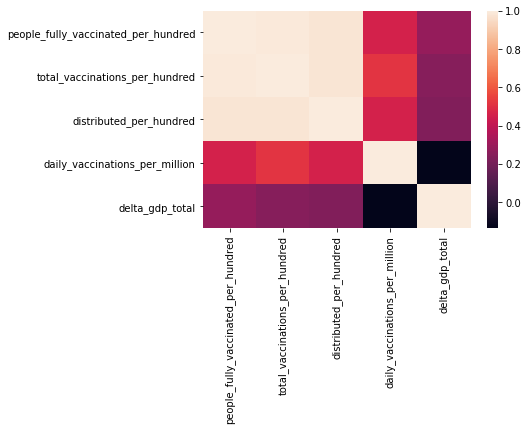

In [211]:
sns.heatmap(summarized_total.corr())

# Try to look for higher correlations for different values of "Description"

The following cell conducts the same analysis except for each possible value of "Description." This accounts for more specific categories.

All industry total
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.286982   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.249099   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

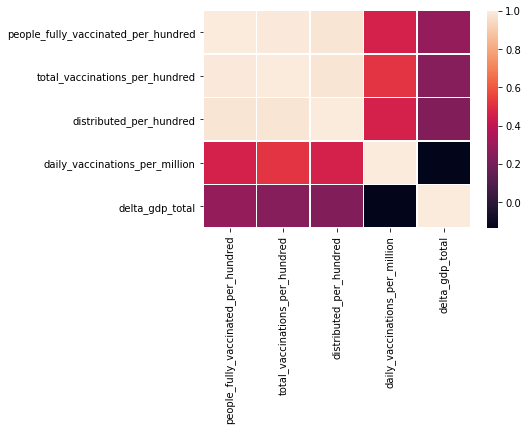

 Private industries
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.225382   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.192680   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hund

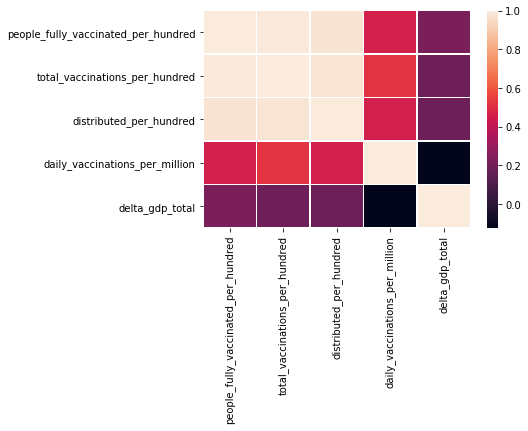

   Agriculture, forestry, fishing and hunting
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.277804   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.228354   

                                     distributed_per_hundred  \
people

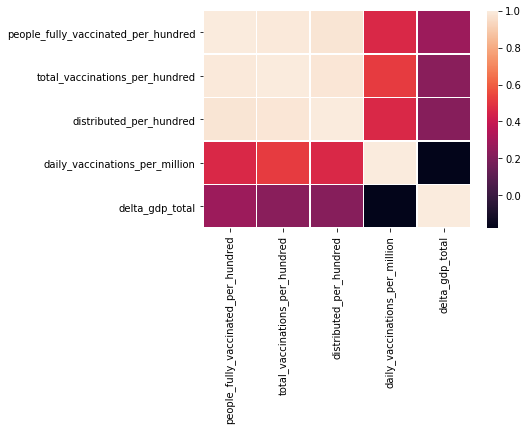

   Mining, quarrying, and oil and gas extraction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.672071   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.662365   

                                     distributed_per_hundred  \
peo

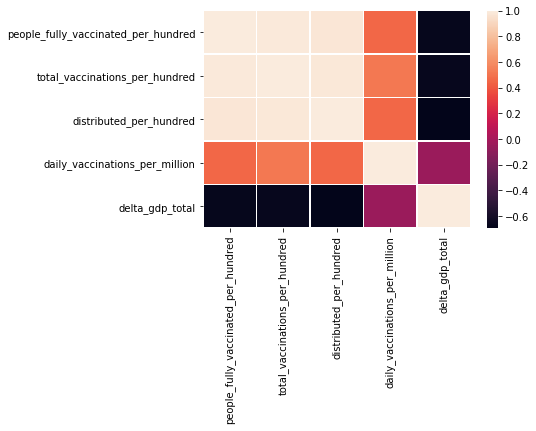

   Utilities
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.701520   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.680522   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred    

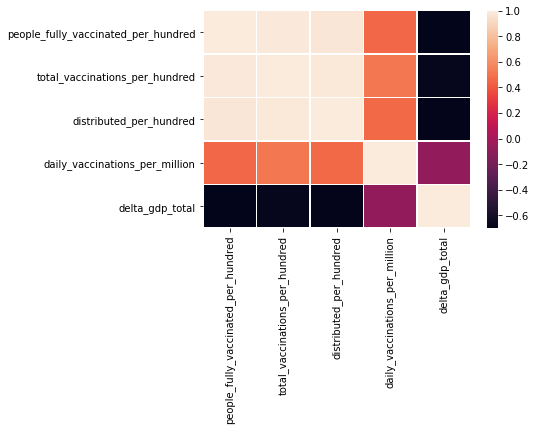

   Construction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.176172   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.173500   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

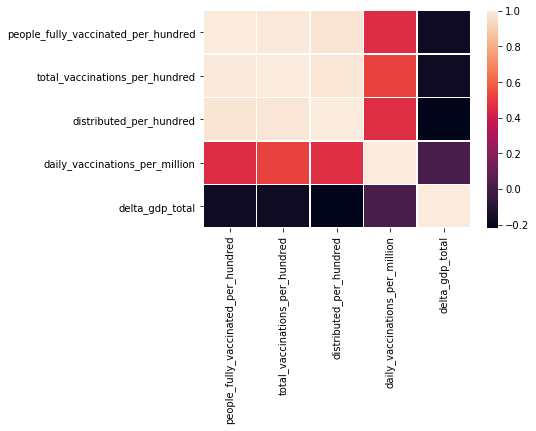

   Manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.192984   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.193137   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred

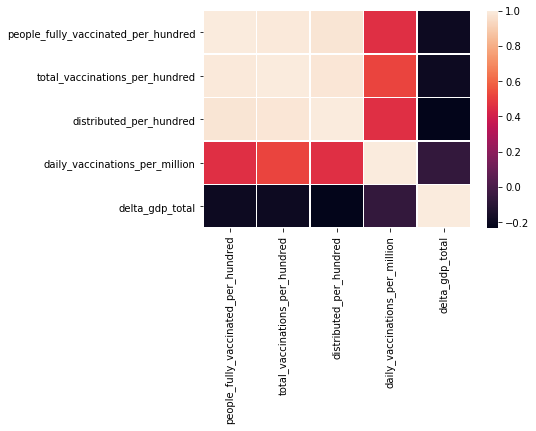

     Durable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.028856   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.063070   

                                     distributed_per_hundred  \
people_fully_vaccin

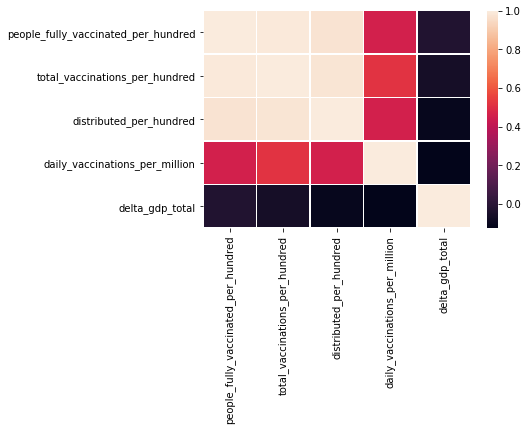

     Nondurable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.387745   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.353959   

                                     distributed_per_hundred  \
people_fully_vac

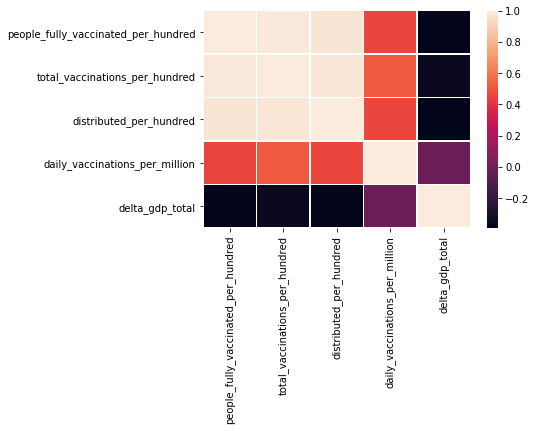

   Wholesale trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.272869   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.302766   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

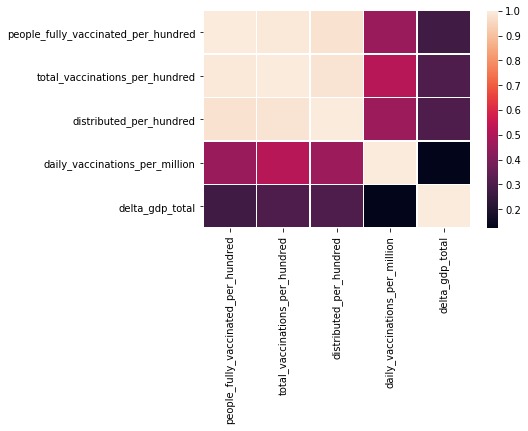

   Retail trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.214287   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.221401   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

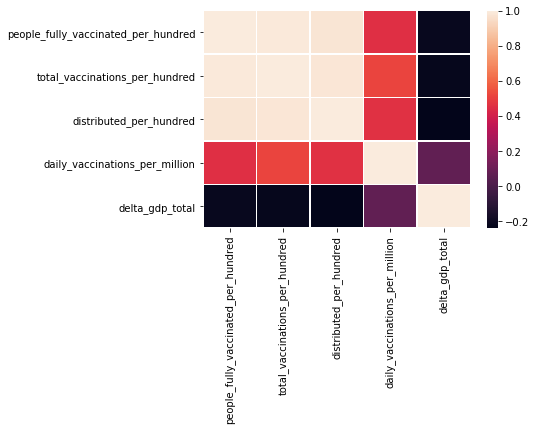

   Transportation and warehousing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.147275   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.167523   

                                     distributed_per_hundred  \
people_fully_vacci

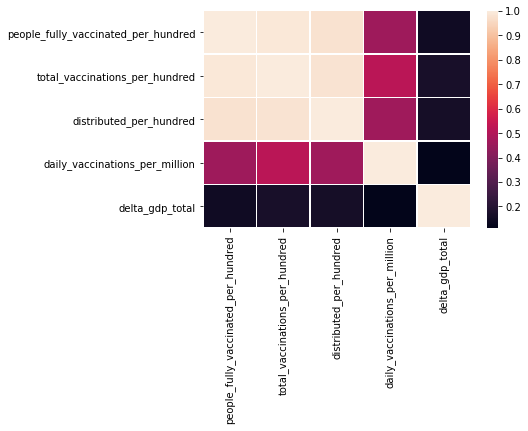

   Information
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.251243   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.242217   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred  

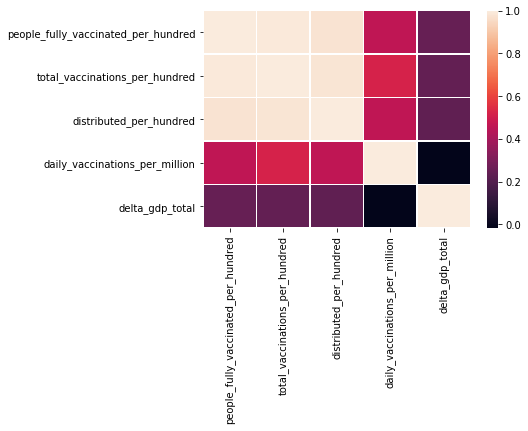

   Finance and insurance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.411410   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.405747   

                                     distributed_per_hundred  \
people_fully_vaccinated_per

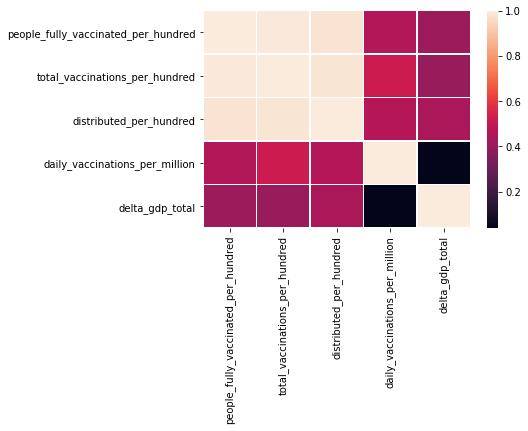

   Real estate and rental and leasing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.732819   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.722732   

                                     distributed_per_hundred  \
people_fully_v

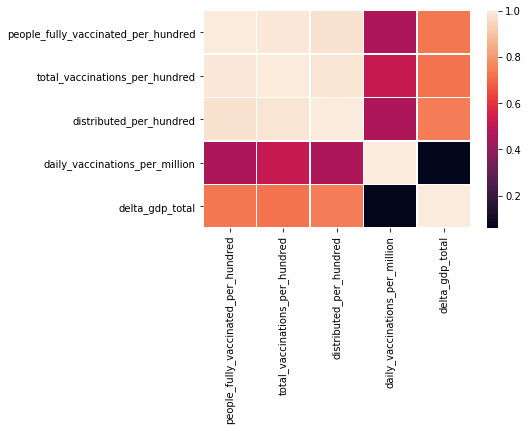

   Professional, scientific, and technical services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.224508   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.206238   

                                     distributed_per_hundred  \


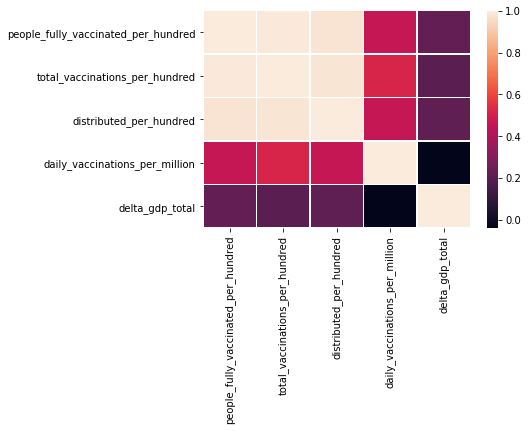

   Management of companies and enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.167719   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.148779   

                                     distributed_per_hundred  \
people_fu

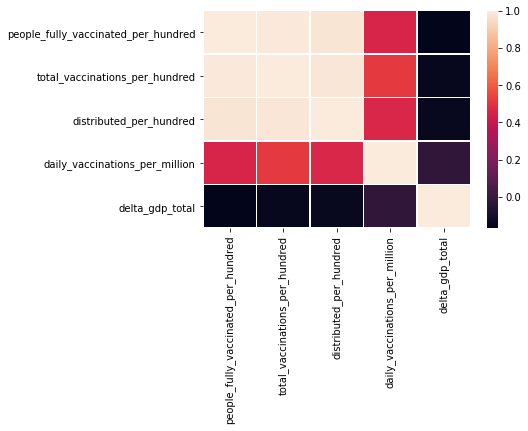

   Administrative and support and waste management and remediation services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.386434   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.382993   

                                     dis

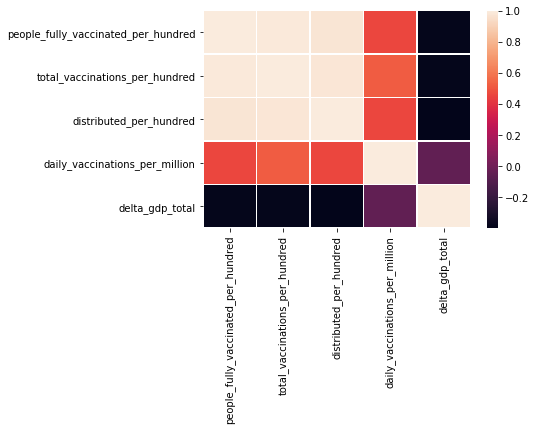

   Educational services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.269307   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.242555   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_

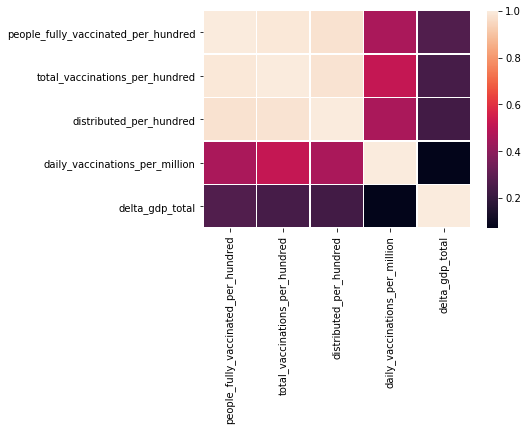

   Health care and social assistance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.310911   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.296878   

                                     distributed_per_hundred  \
people_fully_va

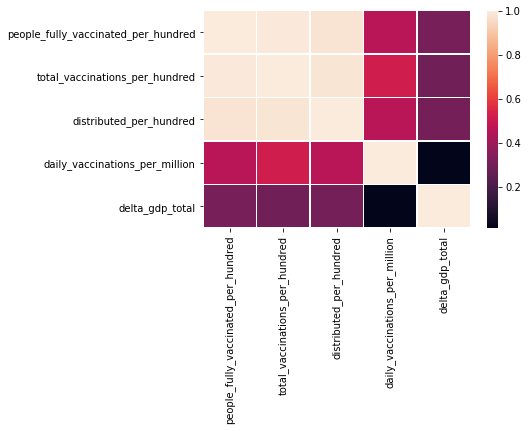

   Arts, entertainment, and recreation
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.106296   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.096398   

                                     distributed_per_hundred  \
people_fully_

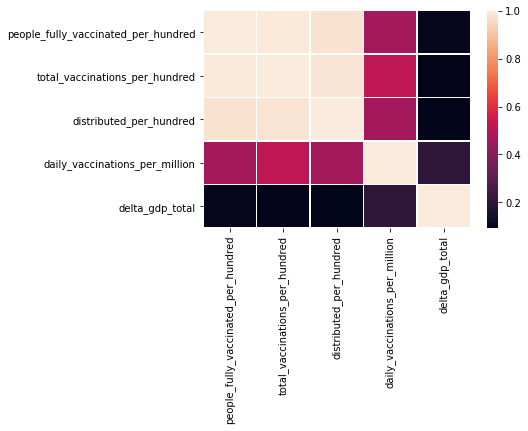

   Accommodation and food services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.787859   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.769063   

                                     distributed_per_hundred  \
people_fully_vacc

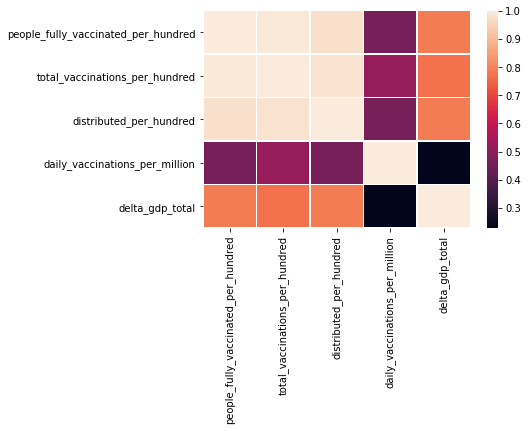

   Other services (except government and government enterprises)
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.830904   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.806970   

                                     distributed_pe

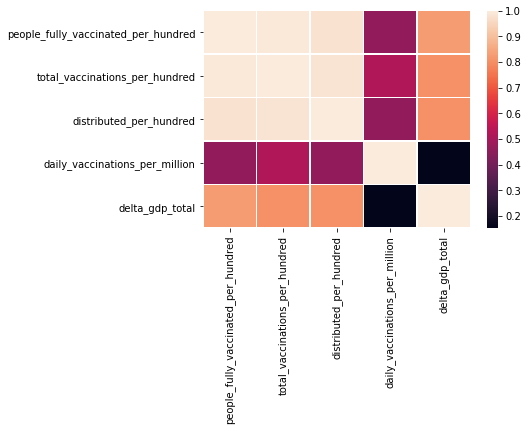

 Government and government enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.307115   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.285692   

                                     distributed_per_hundred  \
people_fully_

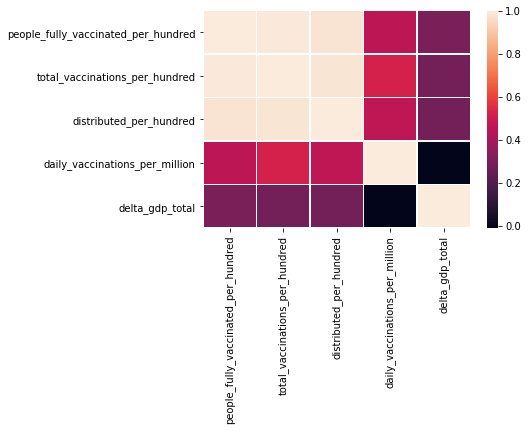

  Federal civilian
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.443541   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.441133   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

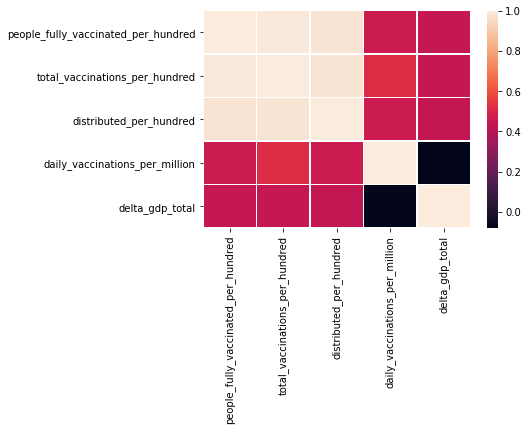

  Military
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                -0.124819   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                           -0.130867   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred      

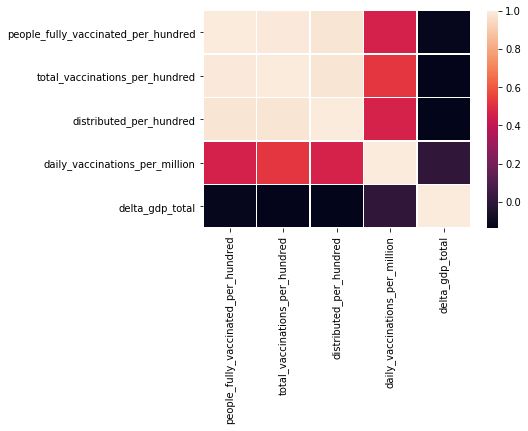

  State and local
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.992580   
distributed_per_hundred                                         0.977877   
daily_vaccinations_per_million                                  0.461389   
delta_gdp_total                                                 0.338849   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.992580   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.981792   
daily_vaccinations_per_million                             0.519804   
delta_gdp_total                                            0.318343   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundre

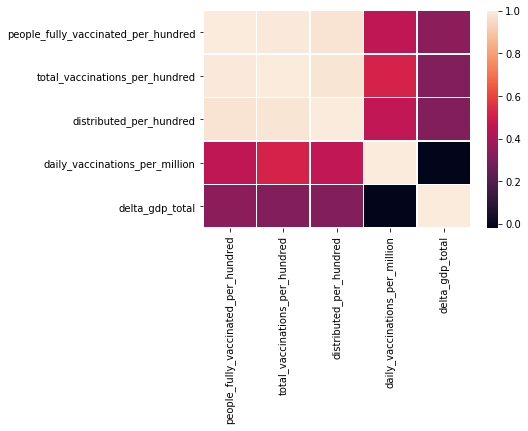

In [212]:
for description_value in gdp_df['Description'].unique():
    gdp_df_total = gdp_df[gdp_df['Description'] == description_value].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
    gdp_df_total.replace('(D)',None,inplace=True)
    delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
    delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)
    summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
    summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
    summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
    summarized_gdp_total.reset_index(drop=True, inplace=True)
    summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*51),pd.Series(['2021:Q2']*51)]).to_list()
    summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])
    
    print(description_value)
    print(summarized_total.corr())
    ax = sns.heatmap(summarized_total.corr(), linewidth=0.5)
    plt.show()

All industry total
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.093629   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.084277   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

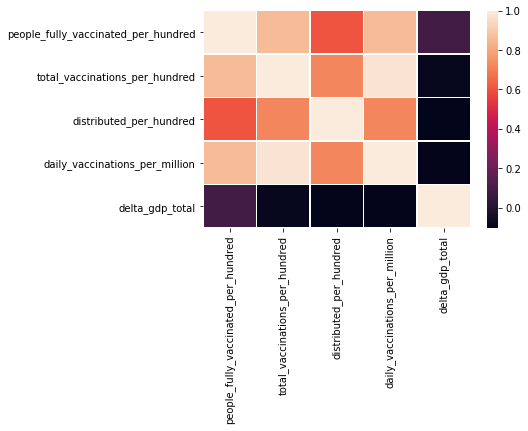

 Private industries
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.184617   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.007086   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hund

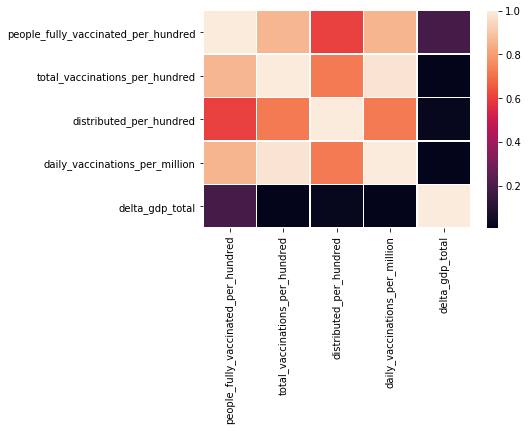

   Agriculture, forestry, fishing and hunting
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.097978   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.136854   

                                     distributed_per_hundred  \
people

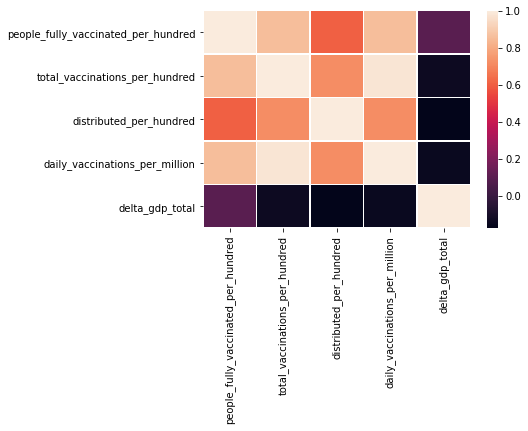

   Mining, quarrying, and oil and gas extraction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.273113   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.185929   

                                     distributed_per_hundred  \
peo

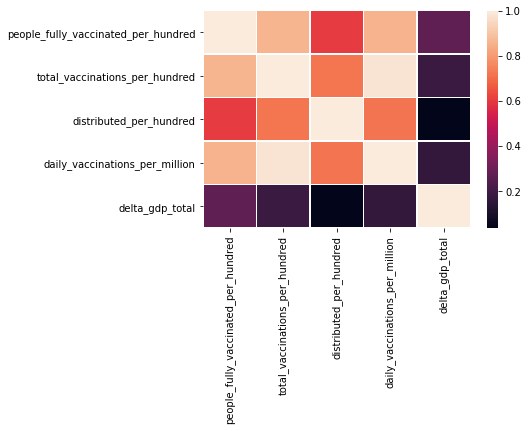

   Utilities
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.089095   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.015155   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred    

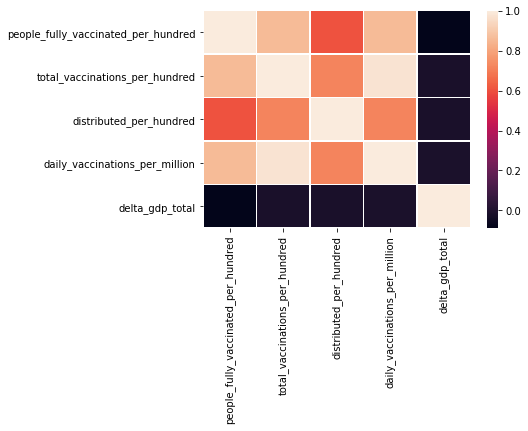

   Construction
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.083988   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.054555   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

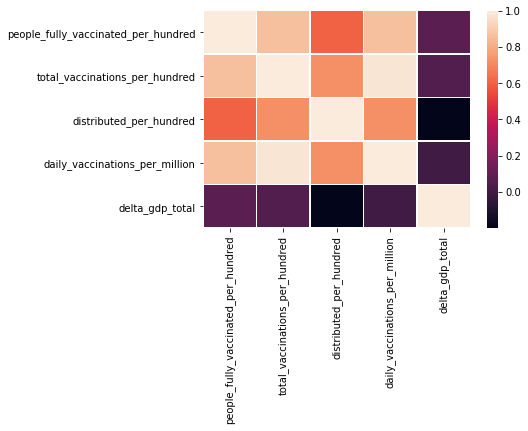

   Manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.136198   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.144227   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred

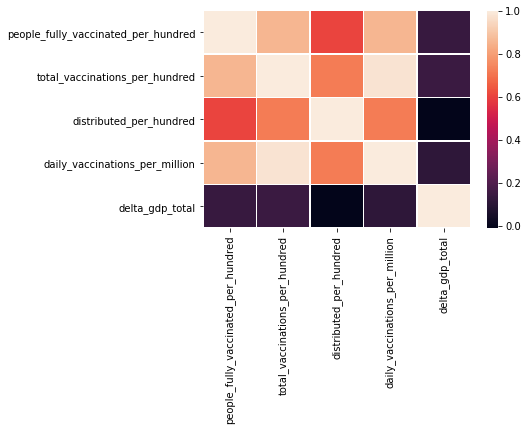

     Durable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.183295   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.081387   

                                     distributed_per_hundred  \
people_fully_vaccin

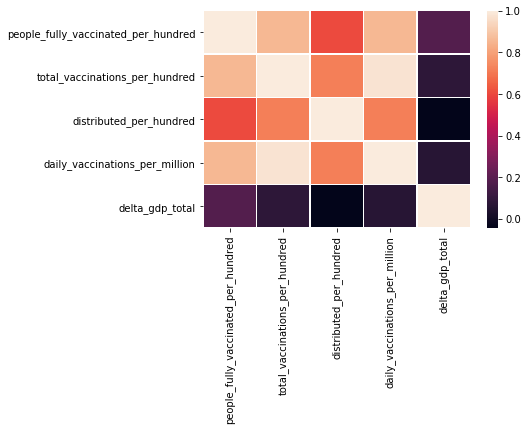

     Nondurable goods manufacturing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.061157   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.129657   

                                     distributed_per_hundred  \
people_fully_vac

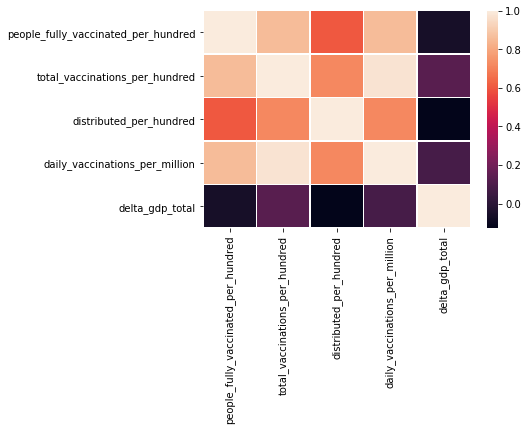

   Wholesale trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.186825   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.045746   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

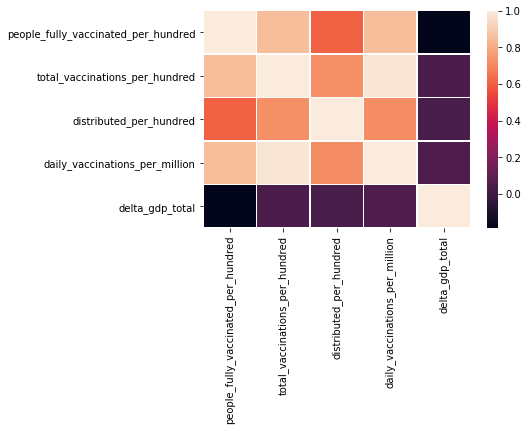

   Retail trade
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.278224   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.090888   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred 

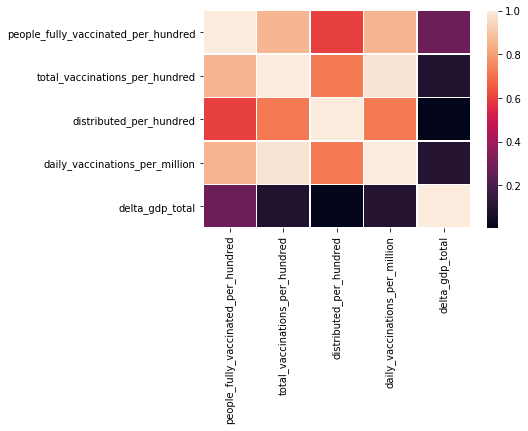

   Transportation and warehousing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.035526   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.081701   

                                     distributed_per_hundred  \
people_fully_vacci

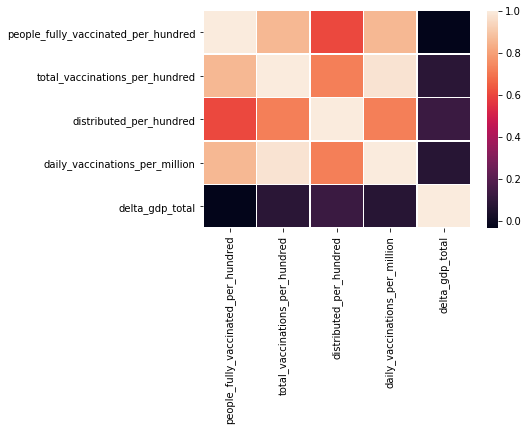

   Information
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.262881   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.224059   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred  

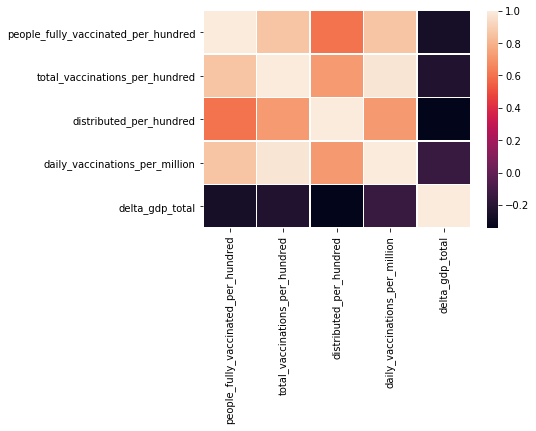

   Finance and insurance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.065279   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.097904   

                                     distributed_per_hundred  \
people_fully_vaccinated_per

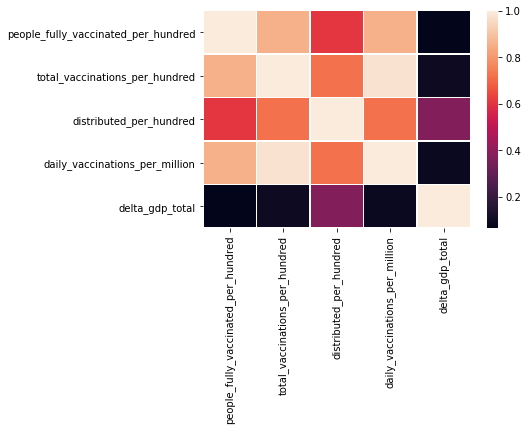

   Real estate and rental and leasing
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.373698   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.321555   

                                     distributed_per_hundred  \
people_fully_v

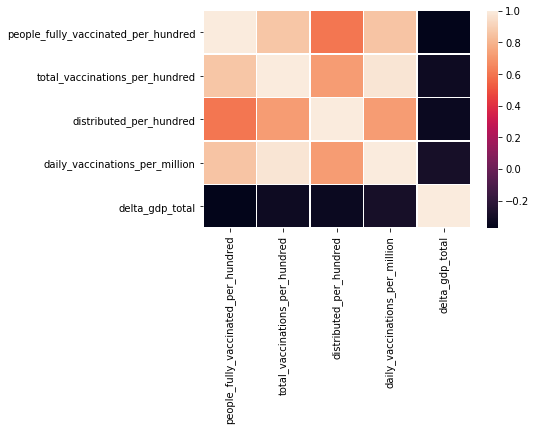

   Professional, scientific, and technical services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.199997   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.284284   

                                     distributed_per_hundred  \


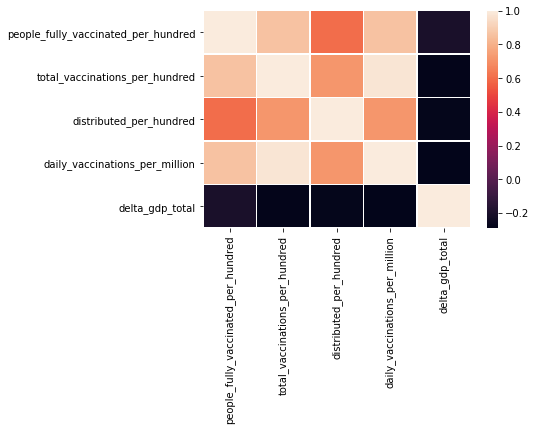

   Management of companies and enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.082309   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.038653   

                                     distributed_per_hundred  \
people_fu

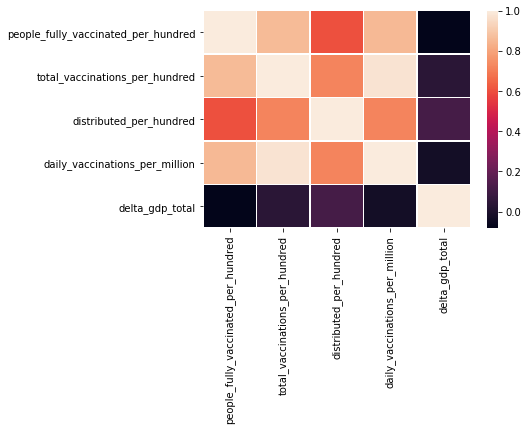

   Administrative and support and waste management and remediation services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.021032   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.055361   

                                     dis

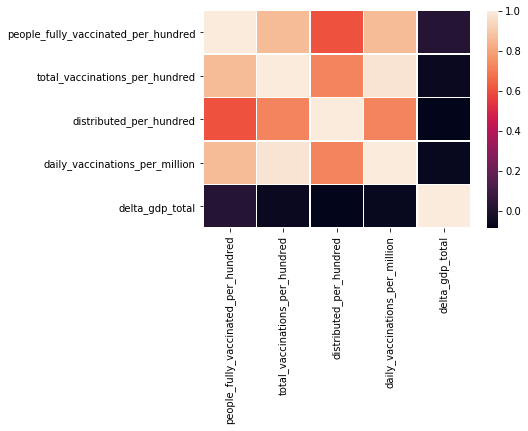

   Educational services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.104958   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.125608   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_

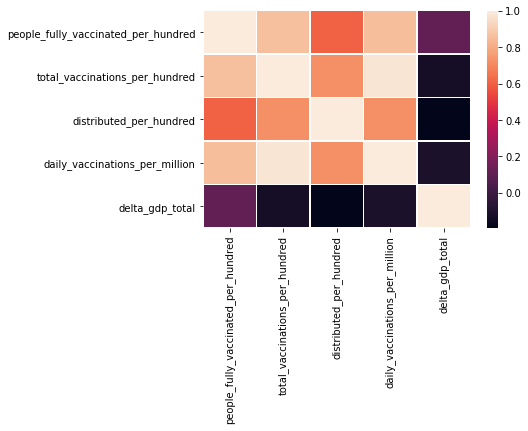

   Health care and social assistance
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.195467   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.234873   

                                     distributed_per_hundred  \
people_fully_va

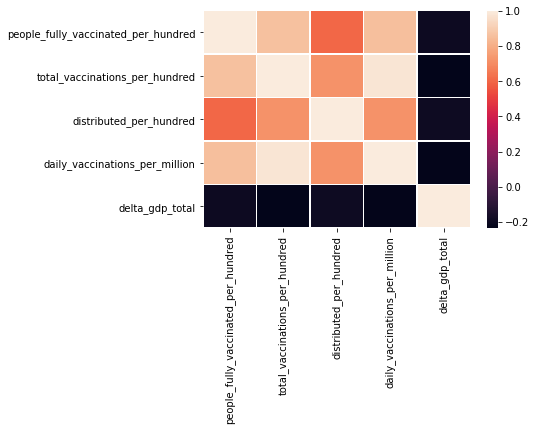

   Arts, entertainment, and recreation
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.008601   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.133888   

                                     distributed_per_hundred  \
people_fully_

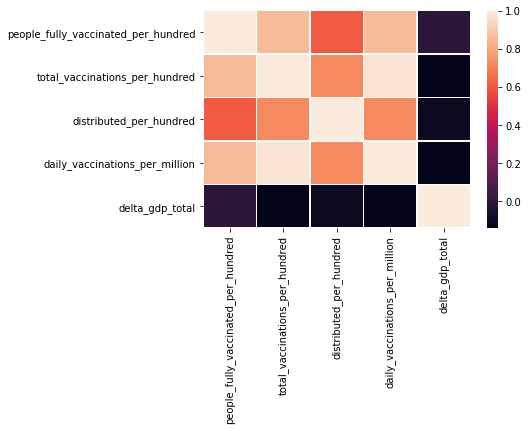

   Accommodation and food services
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.118988   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.038971   

                                     distributed_per_hundred  \
people_fully_vacc

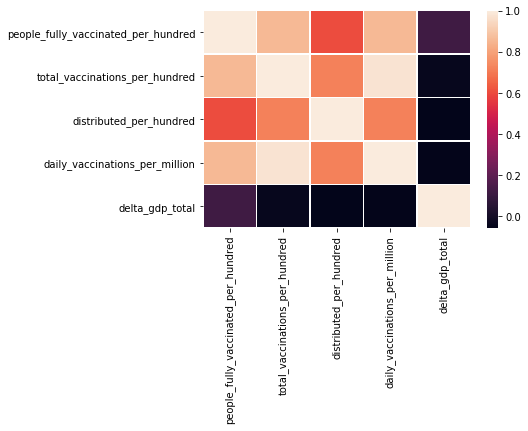

   Other services (except government and government enterprises)
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.021466   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.095770   

                                     distributed_pe

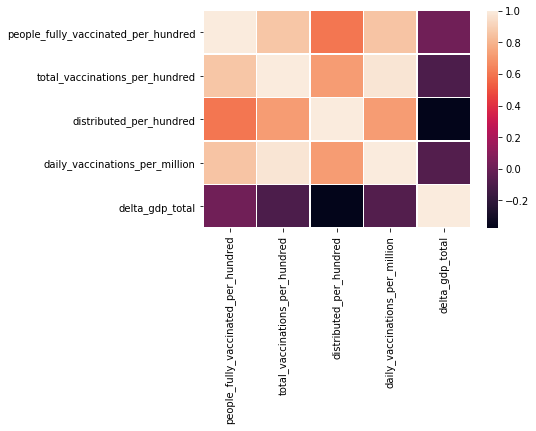

 Government and government enterprises
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.195511   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.265086   

                                     distributed_per_hundred  \
people_fully_

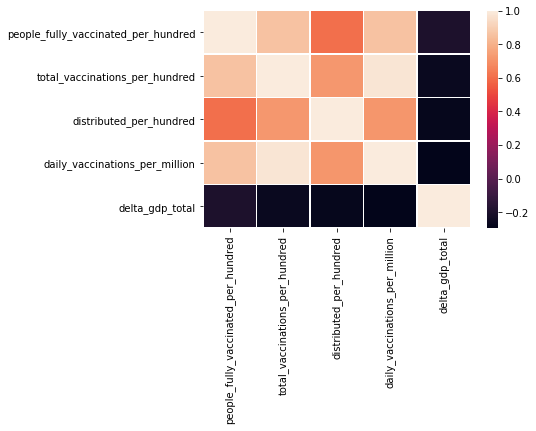

  Federal civilian
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.126056   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.167277   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundr

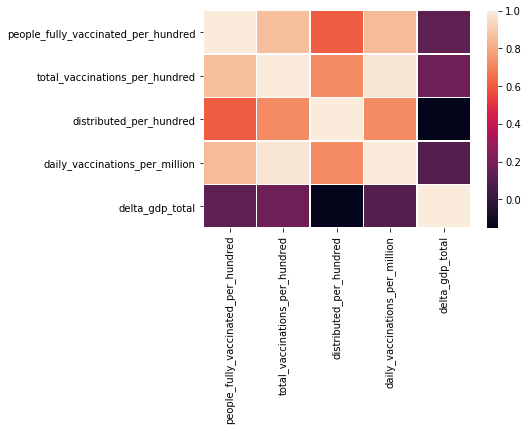

  Military
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                 0.081282   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                            0.000420   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundred      

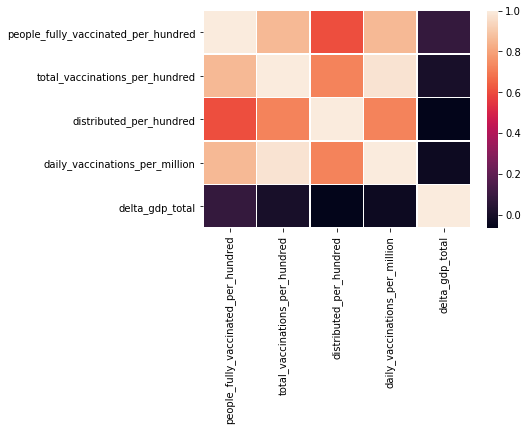

  State and local
                                     people_fully_vaccinated_per_hundred  \
people_fully_vaccinated_per_hundred                             1.000000   
total_vaccinations_per_hundred                                  0.860905   
distributed_per_hundred                                         0.606165   
daily_vaccinations_per_million                                  0.859890   
delta_gdp_total                                                -0.242351   

                                     total_vaccinations_per_hundred  \
people_fully_vaccinated_per_hundred                        0.860905   
total_vaccinations_per_hundred                             1.000000   
distributed_per_hundred                                    0.722303   
daily_vaccinations_per_million                             0.977596   
delta_gdp_total                                           -0.306114   

                                     distributed_per_hundred  \
people_fully_vaccinated_per_hundre

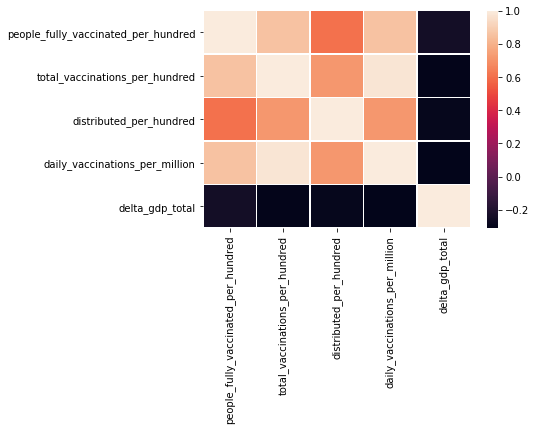

In [191]:
for description_value in gdp_df['Description'].unique():
    gdp_df_total = gdp_df[gdp_df['Description'] == description_value].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
    gdp_df_total.replace('(D)',None,inplace=True)
    delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
    delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)
    summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
    summarized_gdp_total['delta_gdp_total'] = delta_2021_Q1
    summarized_gdp_total['location'] = gdp_df_total['location']
    summarized_gdp_total.reset_index(drop=True, inplace=True)
    summarized_gdp_total['quarter'] = ['2021:Q1']*51
    summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])
    
    print(description_value)
    print(summarized_total.corr())
    ax = sns.heatmap(summarized_total.corr(), linewidth=0.5)
    plt.show()

Categories with reasonable correlation. All industry total -> Private industries:
* Mining, quarrying, and oil and gas extraction
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         -0.672071  
* * total_vaccinations_per_hundred              -0.662365 
* * distributed_per_hundred                     -0.694135  
* * daily_vaccinations_per_million              -0.044844 
* * delta_gdp_total                             1.000000  

* Utilities
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         -0.696827  
* * total_vaccinations_per_hundred              -0.678444   
* * distributed_per_hundred                     -0.694265  
* * daily_vaccinations_per_million              -0.068749  
* * delta_gdp_total                             1.000000  

* Real estate and rental and leasing
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         0.727329  
* * total_vaccinations_per_hundred              0.712016  
* * distributed_per_hundred                     0.731928  
* * daily_vaccinations_per_million              0.022353  
* * delta_gdp_total                             1.000000  

* Accommodation and food services
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         0.782489  
* * total_vaccinations_per_hundred              0.764932  
* * distributed_per_hundred                     0.785389  
* * daily_vaccinations_per_million              0.207062  
* * delta_gdp_total                             1.000000  

* Other services (except government and government enterprises)
* * delta_gdp_total  
* * people_fully_vaccinated_per_hundred         0.833123 
* * total_vaccinations_per_hundred              0.819133 
* * distributed_per_hundred                     0.824039  
* * daily_vaccinations_per_million              0.156794    
* * delta_gdp_total                             1.000000 

Categories with slightly smaller correlation (around .3 - .4)
* Finance and Insurance
* Nondurable goods and manufacturing
* Wholesale trade
* Administrative and support and waste management and remediation services
* Health care and social assistance
* Government and government enterprises
* Federal Civilian
* State and local

Smaller correlation (around .2)
* All industry total
* Private industries
* Agriculture, forestry, fishing and hunting
* Construction
* Manufacturing
* Retail trade
* Transportation and warehousing
* Information
* Professional, scientific, and technical services
* Educational services


# Graphing Results

In [88]:
# Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [239]:
gdp_lr_preprocess = pd.read_csv('../data/gdp-data/SQGDP2__ALL_AREAS_2005_2021.csv')
gdp_lr_preprocess = gdp_lr_preprocess[gdp_lr_preprocess['GeoName'].isin(state_names)]
gdp_lr_preprocess_tot = gdp_lr_preprocess[gdp_lr_preprocess['Description'] == 'All industry total'].drop(['GeoFIPS','TableName','Region','LineCode','IndustryClassification','Description', 'Unit'], axis=1)
gdp_lr_preprocess_a_r = gdp_lr_preprocess[gdp_lr_preprocess['Description'] == '   Accommodation and food services'].drop(['GeoFIPS','TableName','Region','LineCode','IndustryClassification','Description', 'Unit'], axis=1)

In [240]:
X_gdp = pd.DataFrame(columns=['location','time','GDP'])
for index,row in gdp_lr_preprocess_tot.iterrows():
    state_X = pd.DataFrame(columns=['location','time','GDP'])
    state_X['time'] = range(0,66)
    state_X['time'] = state_X['time'].astype(float)
    state_X['GDP'] = row[1:].values.astype(float)
    state_X['location'] = row['GeoName']
    X_gdp = pd.concat([X_gdp,state_X])

X_gdp_a_r = pd.DataFrame(columns=['location','time','GDP_a_r'])
for index,row in gdp_lr_preprocess_a_r.iterrows():
    state_X_a_r = pd.DataFrame(columns=['location','time','GDP_a_r'])
    state_X_a_r['time'] = range(0,66)
    state_X_a_r['time'] = state_X_a_r['time'].astype(float)
    state_X_a_r['GDP_a_r'] = row[1:].values.astype(float)
    state_X_a_r['location'] = row['GeoName']
    X_gdp_a_r = pd.concat([X_gdp_a_r,state_X_a_r])

X_gdp = X_gdp.merge(X_gdp_a_r, on=['location','time'])

In [247]:
X_gdp

,location,time,GDP,GDP_a_r
0,Alabama,0.0,155702.7,3449.9
1,Alabama,1.0,158097.7,3480.3
2,Alabama,2.0,159237.5,3503.2
3,Alabama,3.0,162349.4,3600.4
4,Alabama,4.0,163922.4,3710.8
...,...,...,...,...
3361,Wyoming,61.0,32691.6,920.4
3362,Wyoming,62.0,36473.1,1209.2
3363,Wyoming,63.0,37548.1,1159.5
3364,Wyoming,64.0,39754.9,1172.7


In [246]:
X_gdp[X_gdp['location'] == 'California'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 264 to 329
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  66 non-null     object 
 1   time      66 non-null     float64
 2   GDP       66 non-null     float64
 3   GDP_a_r   66 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.6+ KB


### Graphing GDP w.r.t. time within California

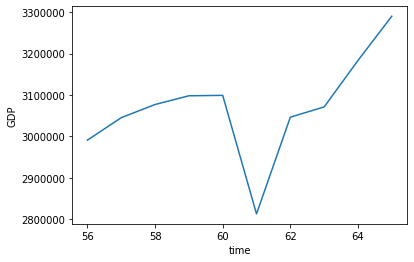

In [231]:
sns.lineplot(data = X_gdp[(X_gdp['location'] == 'California') & (X_gdp['time']>=56)], x='time', y='GDP')

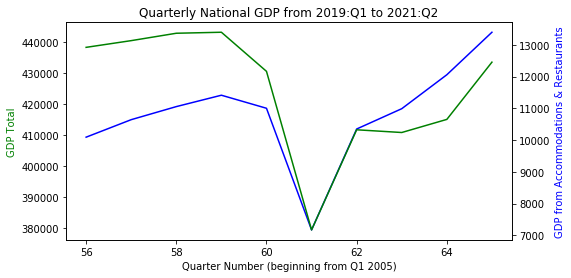

In [264]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(data = X_gdp[(X_gdp['time']>=56)], x='time', y='GDP', ax = ax1, color = 'blue', ci=None) # plots the first set of data, and sets it to ax1. 
sns.lineplot(data = X_gdp[(X_gdp['time']>=56)], x='time', y='GDP_a_r', ax = ax2, color = 'green', ci=None) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('Quarter Number (beginning from Q1 2005)')
ax1.set_ylabel('GDP Total', color='g')
ax2.set_ylabel('GDP from Accommodations & Restaurants', color='b')
ax2.set_title('Quarterly National GDP from 2019:Q1 to 2021:Q2')

fig.set_size_inches(8, 4)
fig.savefig('../images/gdp_over_time.png',dpi=300)




The two graphs above are useful because they shows that not every state's economic recovery occured at the same speed.

### Plotting Vaccination Rates on Map

In [188]:
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True) 

In [189]:
state_abbreviations = pd.read_csv('../data/state_abbreviations.csv')

In [190]:
state_abbreviations.rename(columns={'State':'location'}, inplace=True)

In [214]:
vax_plot_df = summarized_total.merge(state_abbreviations, on='location')


In [218]:
vax_plot_df_1 = vax_plot_df[vax_plot_df['quarter'] == '2021:Q1']
vax_plot_df_2 = vax_plot_df[vax_plot_df['quarter'] == '2021:Q2']

In [227]:
# Plotting the values with plotly
data = dict(type='choropleth',
            colorscale = 'Darkmint',
            reversescale = False,
            locations = vax_plot_df_1['Code'],
            z = vax_plot_df_1['people_fully_vaccinated_per_hundred'],
            locationmode = 'USA-states',
            text = vax_plot_df_1['location'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':"Percent Fully Vaccinated"},
            zmax=65,
            zmin=0
            ) 

layout = dict(title = 'Full Vaccination Rate in 2021 Q1',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

choromap = go.Figure(data = [data],layout = layout)
plot(choromap,validate=False)

'temp-plot.html'

In [228]:
# Plotting the values with plotly
data = dict(type='choropleth',
            colorscale = 'Darkmint',
            reversescale = False,
            locations = vax_plot_df_2['Code'],
            z = vax_plot_df_2['people_fully_vaccinated_per_hundred'],
            locationmode = 'USA-states',
            text = vax_plot_df_2['location'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':"Percent Fully Vaccinated"},
            zmax=65,
            zmin=0
            ) 

layout = dict(title = 'Full Vaccination Rate in 2021 Q2',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

choromap = go.Figure(data = [data],layout = layout)
plot(choromap,validate=False)

'temp-plot.html'

# Causality Analysis

### Difference in Differences
First calculate the values
Then create a plotly plot

In [165]:
gdp_total_dd = gdp_df[gdp_df['Description'] == '   Accommodation and food services'].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
gdp_total_dd.replace('(D)',None,inplace=True)

# First we'll calculate the slope from 2020:Q4 to 2021:Q1 and from 2021:Q1 to 2021:Q2 for overall Rest. GDP
# We divide by the 2020:Q4 GDP to standardize (TODO: try it out)
gdp_total_slope_P1 = (gdp_df_total['2021:Q1'].astype(float)-gdp_df_total['2020:Q4'].astype(float))
gdp_total_slope_P2 = (gdp_df_total['2021:Q2'].astype(float)-gdp_df_total['2021:Q1'].astype(float))

# Next we'll find the expected value based on this rate of change in period 1
gdp_total_dd['2021:Q2 Predictions'] = gdp_total_slope_P1 + gdp_total_dd['2021:Q1'].astype(float)
gdp_total_dd['DiffInDiff'] = (gdp_total_dd['2021:Q2'].astype(float) - gdp_total_dd['2021:Q2 Predictions'])/gdp_total_dd['2021:Q2'].astype(float)

# For a similar style of analysis, we'll calculate the change in slope from the first period to the second period, standardized to the GDP before Covid-19
gdp_total_dd['gdp_delta_slope'] = (gdp_total_slope_P2-gdp_total_slope_P1)

Let's plot the values w/ Plotly

In [169]:
gdp_total_dd = gdp_total_dd.merge(state_abbreviations, on='location', how='left')

In [170]:
gdp_total_dd.head()

,location,2021:Q2,2021:Q1,2020:Q4,2021:Q2 Predictions,DiffInDiff,gdp_delta_slope,Abbrev,Code
0,Alabama,7465.1,6457.2,5893.6,7020.8,0.059517,444.3,Ala.,AL
1,Alaska,1324.0,1147.4,1052.0,1242.8,0.061329,81.2,Alaska,AK
2,Arizona,14618.4,12696.2,11844.4,13548.0,0.073223,1070.4,Ariz.,AZ
3,Arkansas,4391.8,3843.8,3607.7,4079.9,0.071019,311.9,Ark.,AR
4,California,77889.3,65062.9,71876.6,58249.2,0.252154,19640.1,Calif.,CA


In [175]:
# Plotting the values with plotly
data = dict(type='choropleth',
            colorscale = 'Darkmint',
            reversescale = False,
            locations = gdp_total_dd['Code'],
            z = gdp_total_dd['DiffInDiff'],
            locationmode = 'USA-states',
            text = gdp_total_dd['location'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':"Standardized GDP Difference in Difference"}
            ) 

layout = dict(title = 'GDP Difference in Differences After Vaccine Rollout',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

choromap = go.Figure(data = [data],layout = layout)
plot(choromap,validate=False)

'temp-plot.html'

### Regression Discontinuity Analysis

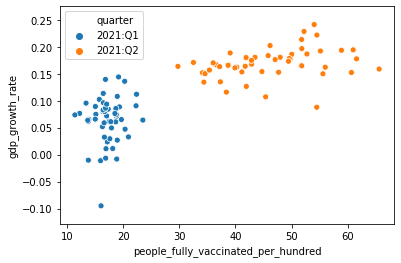

In [95]:
gdp_df_total = gdp_df[gdp_df['Description'] == '   Accommodation and food services'].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
gdp_df_total.replace('(D)',None,inplace=True)
delta_2021_Q1 = (gdp_df_total['2021:Q1'].astype(float)-gdp_df_total['2020:Q4'].astype(float))/(gdp_df_total['2020:Q4'].astype(float))
delta_2021_Q2 = (gdp_df_total['2021:Q2'].astype(float)-gdp_df_total['2021:Q1'].astype(float))/(gdp_df_total['2020:Q4'].astype(float))
summarized_gdp_total = pd.DataFrame(columns=['quarter','location','gdp_growth_rate'])
summarized_gdp_total['gdp_growth_rate'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*51),pd.Series(['2021:Q2']*51)]).to_list()
summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])

sns.scatterplot(data = summarized_total, x='people_fully_vaccinated_per_hundred', y='gdp_growth_rate', hue='quarter')

In [ ]:
# Next we'll calculate the above changes for each state (normalize or nah?)

In [ ]:
# We'll plot this on plotly

# Other stuff

In [ ]:
# New scatter plot that plots the difference between

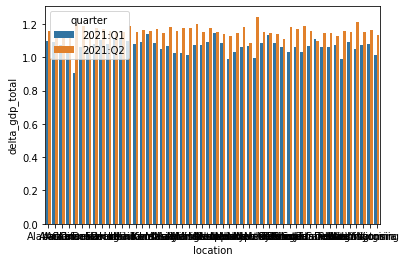

In [35]:
sns.barplot(data = summarized_total, x='location', y='delta_gdp_total', hue='quarter')

In [31]:
summarized_total['delta_gdp_total'] = summarized_total['delta_gdp_total'].astype(float)

# Difference in Differences Analysis for Causality

Looking for casuality in following categories
* Mining, quarrying, and oil and gas extraction
* Utilities
* Accommodation and food services
* Real estate and rental and leasing
* Other services (except government and government enterprises)
* Health care and social assistance
* All industry total

### Linear Regression Predictor of GDP

In order to do the analysis, we must first conduct a linear regression prediction for 2021 GDP using data from 2020. We can also use GDP predictions from other subsidiaries (TODO)

In [32]:
# Training everything w/ onehotencoding instead of training a separate model for individual states
# drop_enc = OneHotEncoder(drop='first').fit(gdp_lr_preprocess)

In [33]:
# train a linear regression per each state
for state in state_names:
    train = gdp_lr_preprocess[gdp_lr_preprocess['GeoName'] == state].drop(['GeoName','2021:Q1', '2021:Q2'], axis=1)
    

In [34]:
for year in range(2005,2022):
    for quarter in range(1,5):
        gdp_lr_preprocess[str(year)+':Q'+str(quarter)] = gdp_lr_preprocess[str(year)+':Q'+str(quarter)]

delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)


summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()

KeyError: '2021:Q3'